In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.stats.mstats import winsorize
from random import seed
from random import random
import seaborn as sns

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [74]:
currencies = ['eth', 'btc', 'doge', 'bnb', 'ada']
string = ['no', 'low', 'medium-low', 'medium-high']
fee_spot_lst = [0.0, 0.00015, 0.000375, 0.000525]
fee_perp_lst = [0.0, 0.0, 0.000054, 0.000108]

fee_spot = fee_spot_lst[2]
fee_perp = fee_perp_lst[2]

threshold_lst = list(np.arange(.0,1.0,0.05))
threshold = threshold_lst[9]
threshold2 = 0.2

notional = 1000000.0
plot = True
wins = False

In [75]:
def load_data(load):
    spot = pd.read_csv(f'data/spot_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp = pd.read_csv(f'data/perp_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp.sort_values(by = 'epoch', ascending=True, inplace=True)
    spot.sort_values(by = 'epoch', ascending=True, inplace=True)
    perp = perp.reset_index(drop=True)
    spot = spot.reset_index(drop=True)
    funding_rate = pd.read_csv(f'data/rate_{load}_usdt.csv', parse_dates=['timestamp'])
    return spot, perp, funding_rate

def create_panel(spot, perp, funding_rate):
    panel = perp[['epoch', 'timestamp', 'close', 'usd_volume']]
    panel['day'] = panel['timestamp'].dt.round('D')
    panel = panel.rename(columns={'close': 'perp', 'usd_volume': 'perp_usd_volume'})
    panel = pd.merge(panel, spot[['epoch', 'close', 'usd_volume']], on='epoch', how='left')
    panel = panel.rename(columns={'close': 'spot', 'usd_volume': 'spot_usd_volume'})
    panel = pd.merge(panel, funding_rate[['epoch', 'funding_rate']], on='epoch', how='left')
    panel.sort_values(by = 'epoch', ascending=True, inplace=True)
    panel = panel.reset_index(drop=True)
    return panel

panel_all = []
for i in range (0,len(currencies)):
    spot, perp, funding_rate = load_data(currencies[i])
    panel_temp = create_panel(spot, perp, funding_rate)
    panel_all.append(panel_temp)
for i in range (0,len(currencies)):
    T = 1/(3*365)
    panel_all[i]['cip'] = -(1/T)*(np.log(panel_all[i]['perp']) - np.log(panel_all[i]['spot'])) 
    if wins:
        panel_all[i]['cip'] = winsorize(panel_all[i]['cip'], limits = (0.025, 0.025))
    mean = np.round(panel_all[i]['cip'].mean(),4)
    days = (panel_all[i]['day'].iloc[-1] - panel_all[i]['day'].iloc[0]).days
#     print(f'{currencies[i]}: The mean deviation from the covered interest rate parity is {mean*100}%. Sampled from Binance over {days} days.')

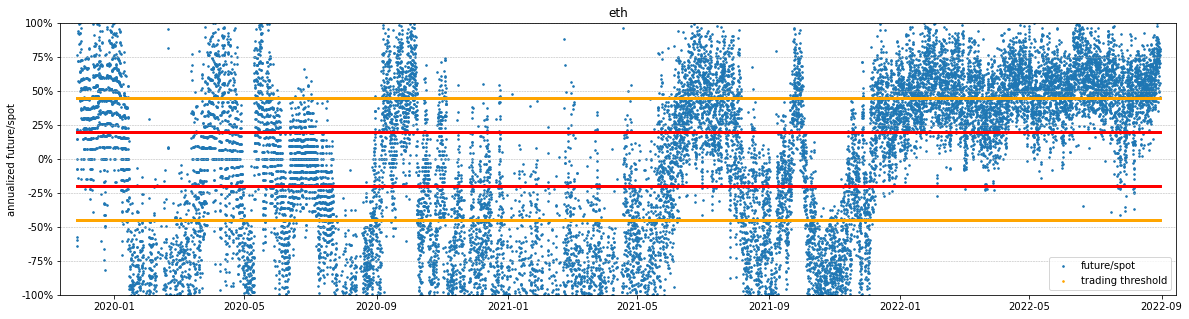

In [76]:
# for i in range (0,len(currencies)):
i = 0
#plotting the cip over time
sns.color_palette()
panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize =(20,5))
ax.scatter(panel_all[i]['timestamp'], panel_all[i]['cip'], s=2.5)
ax.scatter(panel_all[i]['timestamp'], threshold * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'orange')
ax.scatter(panel_all[i]['timestamp'], -threshold * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'orange')
ax.scatter(panel_all[i]['timestamp'], threshold2 * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'red')
ax.scatter(panel_all[i]['timestamp'], -threshold2 * np.ones(len(panel_all[i]['cip'])), s = 2.5, color = 'red')
ax.set_ylim(-1, 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
left, right = plt.xlim()
ax.set_xlim(left+35, right-35)
ax.legend(['future/spot', 'trading threshold'], loc='lower right')
ax.set_ylabel('annualized future/spot')
ax.grid(axis='y', linestyle='--', linewidth=.5)
plt.title(f'{currencies[i]}')
# plt.savefig(f'deviation_{i}.png')
plt.show()

In [77]:
cutoff = '2022-06-01 12:00:00'

eth_start = '2019-11-27 07:00:00'
btc_start = '2019-09-10 08:00:00'
doge_start = '2020-07-10 09:00:00'
bnb_start = '2020-02-10 08:00:00'
ada_start = '2020-01-31 08:00:00'


for i in range (0,len(currencies)):
    panel_all[i] = panel_all[i][panel_all[i]['timestamp'] <= cutoff] #cutoff, such that all data is equally long

In [78]:
#fill or drop na
for i in range (0,len(currencies)):

    panel_all[i]['spot'] = panel_all[i]['spot'].fillna(method='ffill')
    panel_all[i]['spot_usd_volume'] = panel_all[i]['spot_usd_volume'].fillna(method='ffill')
    panel_all[i]['funding_rate'] = panel_all[i]['funding_rate'].fillna(0)
    panel_all[i]['iusdt'] = 0
    #panel_all[i] = panel_all[i].dropna()
    panel_all[i].sort_values(by = 'epoch', ascending=True, inplace=True)
    panel_all[i] = panel_all[i].reset_index(drop=True)

In [79]:
def open_long_position(ethusdt_spot, ethusdt_perp, cash_acc):
    position_spot = share_spot*(cash_acc/ethusdt_spot)*(1-fee_spot)
    position_perp = share_perp*(cash_acc/ethusdt_perp)*(1-fee_perp)*-1
    fee = cash_acc*(share_spot*fee_spot+share_perp*fee_perp)
    cash_acc = 0
    
    return position_spot, position_perp, cash_acc, fee

def close_long_position(position_spot, position_perp, ethusdt_spot, ethusdt_perp, cash_acc):
    spot_value = position_spot*ethusdt_spot
    perp_value = (position_perp*-1)*(buyin_perp*2-ethusdt_perp)
    
    fee = spot_value*fee_spot+perp_value*fee_perp
    cash_acc = cash_acc+spot_value*(1-fee_spot)+perp_value*(1-fee_perp)
    
    position_spot = 0
    position_perp = 0
    
    return position_spot, position_perp, cash_acc, fee

def open_short_position(ethusdt_spot, ethusdt_perp, cash_acc):
    position_spot = share_spot*(cash_acc/ethusdt_spot)*(1-fee_spot)*-1
    position_perp = share_perp*(cash_acc/ethusdt_perp)*(1-fee_perp)
    fee = cash_acc*(share_spot*fee_spot+share_perp*fee_perp)
    cash_acc = 0
    
    return position_spot, position_perp, cash_acc, fee

def close_short_position(position_spot, position_perp, ethusdt_spot, ethusdt_perp, cash_acc):
    spot_value = (position_spot*-1)*(buyin_spot*2-ethusdt_spot)
    perp_value = position_perp*ethusdt_perp
    
    fee = spot_value*fee_spot+perp_value*fee_perp
    cash_acc = cash_acc+spot_value*(1-fee_spot)+perp_value*(1-fee_perp)
    
    position_spot = 0
    position_perp = 0
    
    return position_spot, position_perp, cash_acc, fee

In [80]:
def calculate_equity(position_spot, position_perp, cash_acc, equity):
    equity_old = equity

    if spot == 'long':
        spot_value = position_spot*ethusdt_spot
        perp_value = (position_perp*-1)*(buyin_perp*2-ethusdt_perp)

    elif spot == 'short':
        spot_value = (position_spot*-1)*(buyin_spot*2-ethusdt_spot)
        perp_value = position_perp*ethusdt_perp
    
    else: #no position
        spot_value = 0.0
        perp_value = 0.0

    equity = cash_acc + spot_value + perp_value
    pnl = equity - equity_old
    return equity, pnl, spot_value, perp_value

In [81]:
def calculate_payment(position_perp, ethusdt_perp, funding_rate):
    fr_facevalue = position_perp*ethusdt_perp*-1 #*-1 -> if funding_rate < 0 short perps, pay long perps
    payment = fr_facevalue * funding_rate
    return payment

In [82]:
#calculating the distribution according to fees
share_spot = (1-fee_perp)/(2-fee_spot-fee_perp)
share_perp = 1-share_spot

df_all = []

for t in range(0, len(currencies)):
    panel = panel_all[t]
    #starting variables
    lst=[]
    position_open = False
    position_spot = 0.0
    position_perp = 0.0
    cash_acc = notional

    spot = 'none'

    equity = cash_acc
    turnover = 0.0
    buyin_spot = 0.0
    buyin_perp = 0.0


    for i in range(0, len(panel)):
        action = False

        cip = panel['cip'][i]
        ethusdt_spot = panel['spot'][i]
        ethusdt_perp = panel['perp'][i]
        fee = 0.0

        if cip < -threshold: #cip smaller than threshold; short perp, long spot            

            if position_open == False:
                turnover = turnover + cash_acc
                position_spot, position_perp, cash_acc, fee = open_long_position(ethusdt_spot, ethusdt_perp, cash_acc)
                buyin_spot = ethusdt_spot
                buyin_perp = ethusdt_perp

                position_open = True
                action = True
                spot = 'long'

            elif position_open == True:
                if spot == 'long':
                    pass      

                elif spot == 'short':
                    position_spot, position_perp, cash_acc, fee_temp1 = close_short_position(position_spot, position_perp, ethusdt_spot, ethusdt_perp, cash_acc)
                    turnover = turnover + cash_acc*2
                    position_spot, position_perp, cash_acc, fee_temp2 = open_long_position(ethusdt_spot, ethusdt_perp, cash_acc)
                    buyin_spot = ethusdt_spot
                    buyin_perp = ethusdt_perp
                    
                    fee = fee_temp1 + fee_temp2

                    action = True
                    spot = 'long'
                
#         else:
        elif (cip > -threshold2): #cip is within no-action zone       
            if position_open == False:
                pass

            elif position_open == True:
                if spot == 'long':
                    position_spot, position_perp, cash_acc, fee = close_long_position(position_spot, position_perp, ethusdt_spot, ethusdt_perp, cash_acc)
                    turnover = turnover + cash_acc

                elif spot == 'short':
                    position_spot, position_perp, cash_acc, fee = close_short_position(position_spot, position_perp, ethusdt_spot, ethusdt_perp, cash_acc)
                    turnover = turnover + cash_acc

                buyin_spot = 0.0
                buyin_perp = 0.0

                position_open = False
                action = True
                spot = 'none'
                
        elif (cip >= -threshold) & (cip <= -threshold2):
            if position_open == False:
                pass
            
            elif position_open == True:
                if spot == 'long':
                    pass
                
                elif spot == 'short':
                    position_spot, position_perp, cash_acc, fee_temp1 = close_short_position(position_spot, position_perp, ethusdt_spot, ethusdt_perp, cash_acc)
                    turnover = turnover + cash_acc*2
                    position_spot, position_perp, cash_acc, fee_temp2 = open_long_position(ethusdt_spot, ethusdt_perp, cash_acc)
                    buyin_spot = ethusdt_spot
                    buyin_perp = ethusdt_perp
                    
                    fee = fee_temp1 + fee_temp2

                    action = True
                    spot = 'long'
                
        payment = calculate_payment(position_perp, ethusdt_perp, panel['funding_rate'][i])
        cash_acc = cash_acc + payment
        equity, pnl, spot_value, perp_value = calculate_equity(position_spot, position_perp, cash_acc, equity)
        lst.append([panel['epoch'][i], panel['timestamp'][i], position_open, cash_acc, equity, payment, position_spot, position_perp, fee, cip, panel['funding_rate'][i],  buyin_spot, buyin_perp, ethusdt_spot, ethusdt_perp, pnl, action, turnover, spot, spot_value, perp_value])


    df = pd.DataFrame(lst, columns=['epoch', 'timestamp', 'position_open', 'cash_acc', 'equity', 'funding_payment', 'position_spot', 'position_perp', 'fee', 'cip', 'funding_rate', 'buyin_spot', 'buyin_perp', 'ethusdt_spot', 'ethusdt_perp', 'pnl_position', 'action','turnover', 'spot', 'spot_value', 'perp_value'])
    df['cash_acc'] = df['cash_acc'].astype('int')
    df['equity'] = df['equity'].astype('int')
    df['funding_payment'] = df['funding_payment'].astype('int')
    df['pnl_position'] = df['pnl_position'].astype('int')
    
    df['equity_adj'] = df[df['position_open'] == True]['cash_acc'] #we adjust the equity by incorporating negative balances from the cash acc
    df['equity_adj'] = df['equity_adj'].fillna(0) #if the position has been closed, the equity is automatically updated; if its open, there might be some margin balance
    df['equity_adj'] = df['equity_adj'] + df['equity']
    df['equity_adj'] = df['equity_adj'].astype('int')
    
    df['return'] = 0.0
    df['return'].iloc[0] = (df['equity_adj'].iloc[0]/notional) - 1
    df['return'][1:] = (df['equity_adj'][1:].values/df['equity_adj'][0:-1].values) - 1

    df_all.append(df)

In [83]:
#we calculate the statistics mean, std for each year
return_all = []
return_ann_all = []
return_std_all = []
return_ann_std_all = []
risk_free_all = []
trades_all = []
turnover_all = []
fee_all = []

for i in range(0, len(currencies)):
    return_temp = []
    return_ann_temp = []
    return_std_temp = []
    return_ann_std_temp = []
    risk_free_temp = []
    trades_temp = []
    turnover_temp = []
    fee_temp = []
    
    if df_all[i]['timestamp'].dt.year.iloc[0] != 2019: #if timeseries starts after 2019
        return_temp.append(0)
        return_ann_temp.append(0)
        return_std_temp.append(0)
        return_ann_std_temp.append(0)
        risk_free_temp.append(0)
        fee_temp.append(0)
        trades_temp.append(0)
        turnover_temp.append(0)

    
    for j in range(df_all[i]['timestamp'].dt.year.iloc[0], df_all[i]['timestamp'].dt.year.iloc[-1]+1):     
        
        return_temp.append(df_all[i][df_all[i]['timestamp'].dt.year == j]['return'].mean()*24)
        return_ann_temp.append(df_all[i][df_all[i]['timestamp'].dt.year == j]['return'].mean()*24*365)

        return_std_temp.append(df_all[i][df_all[i]['timestamp'].dt.year == j]['return'].std()*np.sqrt(24))
        return_ann_std_temp.append(df_all[i][df_all[i]['timestamp'].dt.year == j]['return'].std()*np.sqrt(24*365))
  
        risk_free_temp.append(panel_all[i][panel_all[i]['timestamp'].dt.year == j]['iusdt'].mean())

        #relative fees paid: fees/(net_equity+fees)
        #fee_temp.append(df_all[i][df_all[i]['timestamp'].dt.year == j]['fee'].sum()/(df_all[i][(df_all[i]['timestamp'].dt.year == j)]['equity_adj'].iloc[-1]+df_all[i][df_all[i]['timestamp'].dt.year == j]['fee'].sum()))
        fee_temp.append(df_all[i][df_all[i]['timestamp'].dt.year == j]['fee'].sum())
        
        trades_temp.append(df_all[i][(df_all[i]['timestamp'].dt.year == j) & (df_all[i]['action'] == True)]['action'].count())
    
        turnover_temp.append(df_all[i][(df_all[i]['timestamp'].dt.year == j)]['turnover'].iloc[-1]-df_all[i][(df_all[i]['timestamp'].dt.year == j)]['turnover'].iloc[0])
    

    return_temp.append(df_all[i]['return'].mean()*24) #mean
    return_all.append(return_temp)
    
    return_ann_temp.append(df_all[i]['return'].mean()*24*365) #mean
    return_ann_all.append(return_ann_temp)
    
    return_std_temp.append(df_all[i]['return'].std()*np.sqrt(24)) #mean
    return_std_all.append(return_std_temp)
    
    return_ann_std_temp.append(df_all[i]['return'].std()*np.sqrt(24*365)) #mean
    return_ann_std_all.append(return_ann_std_temp)
    
    risk_free_temp.append(panel_all[i]['iusdt'].mean()) #mean
    risk_free_all.append(risk_free_temp)
    
    fee_temp.append(sum(fee_temp)/len(fee_temp)) #mean
    fee_all.append(fee_temp)
    
    trades_temp.append(sum(trades_temp)/len(trades_temp)) #mean
    trades_all.append(trades_temp)
    
    turnover_temp.append(sum(turnover_temp)/len(turnover_temp)) #mean
    turnover_all.append(turnover_temp)
    

In [84]:
#unlisting list for dataframe of results
return_all = [np.round(item,6) for sublist in return_all for item in sublist]
return_std_all = [np.round(item,6) for sublist in return_std_all for item in sublist]
return_ann_all = [np.round(item,6) for sublist in return_ann_all for item in sublist]
return_ann_std_all = [np.round(item,6) for sublist in return_ann_std_all for item in sublist]

risk_free_all = [np.round(item,6) for sublist in risk_free_all for item in sublist]
fee_all = [np.round(item,4) for sublist in fee_all for item in sublist]
trades_all = [int(item) for sublist in trades_all for item in sublist]
turnover_all = [int(item/1e6) for sublist in turnover_all for item in sublist]

risk_free_all_daily = [item/365 for item in risk_free_all]

sharpe = [(i-j)/k for i,j,k in zip(return_all, risk_free_all_daily, return_std_all)]
sharpe = pd.Series(sharpe).fillna(0).tolist()
sharpe = [np.round(item,4) for item in sharpe]

sharpe_ann = [(i-j)/k for i,j,k in zip(return_ann_all, risk_free_all, return_ann_std_all)]
sharpe_ann = pd.Series(sharpe_ann).fillna(0).tolist()
sharpe_ann = [np.round(item,4) for item in sharpe_ann]

In [85]:
def compute_autoregression(inpt, lags, plot):
    from statsmodels.tsa.ar_model import AutoReg
    from statsmodels.tsa.stattools import adfuller
    
    #conducting stationarity test
    df_stationarityTest = adfuller(inpt, autolag='AIC')
    if df_stationarityTest[1] > 0.05:
        print('Data is not stationary!')

    if plot:
        from statsmodels.graphics.tsaplots import plot_pacf
        pacf = plot_pacf(inpt, lags=25)
        plt.show()
        
    train_data = inpt[:len(inpt)-10]
    test_data = inpt[len(inpt)-10:]
    ar_model = AutoReg(train_data, lags=lags).fit()
    if plot:
        print(ar_model.summary())
    
    return ar_model.params

In [86]:
def calculate_sharpe_adj(q, k, p, sharpe):
    sm = 0
    for t in range(1, len(p)): # p is params of ar(lag), whereas the first, the coefficient, is skipped.
        sm += (q-k)*p[t]
        
    n = q / np.sqrt(q+2*sm)
    
    sharpe_adj = sharpe * n
    return sharpe_adj

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
ar1_params = []
lags = 1 #lags of autocorrelation
periods = 365 #days of the year

for i in range(0, len(currencies)):

    if df_all[i]['timestamp'].dt.year.iloc[0] != 2019: #if timeseries starts after 2019
        ar1_params.append([0,0])

    for j in range(df_all[i]['timestamp'].dt.year.iloc[0], df_all[i]['timestamp'].dt.year.iloc[-1]+1):
        ar1_params.append(compute_autoregression(inpt=df_all[i][df_all[i]['timestamp'].dt.year == j]['return'], lags=lags, plot=False))

    ar1_params.append(compute_autoregression(inpt=df_all[i]['return'], lags=lags, plot=False)) #for all years

sharpe_ar1 = []

for t in range(0, len(ar1_params)):
    p = ar1_params[t]
    sharpe_ar1.append(calculate_sharpe_adj(q=periods, k=lags, p=p, sharpe=sharpe[t].copy()))

In [89]:
iterables = [currencies, ['2019', '2020', '2021', '2022', 'mean']]

index = pd.MultiIndex.from_product(iterables)

results = pd.DataFrame(
    {'daily_return': return_all,
    'daily_std': return_std_all,
    'sharpe': sharpe,
    'ann_return': return_ann_all,
    'ann_std': return_ann_std_all,
    'ann_risk_free': risk_free_all,
    'ann_sharpe': sharpe_ann,
    'ann_sharpe_ar1': sharpe_ar1,
    'fees': fee_all,
    'trades': trades_all,
    'turnover': turnover_all},index = index)

In [90]:
for col in results.columns:
    results[col] = pd.to_numeric(results[col])
    results[col] = round(results[col],3)

In [91]:
# display(results)
results[['ann_return', 'ann_std', 'ann_sharpe', 'trades', 'turnover']]#[['fees', 'trades', 'turnover']]

ann_return  ann_std  ann_sharpe  trades  turnover
eth  2019      -0.012    0.002      -5.187      16        15
     2020       0.116    0.040       2.863     583       623
     2021       0.164    0.051       3.223     491       628
     2022       0.013    0.009       1.501       2         2
     mean       0.113    0.041       2.748     273       317
btc  2019       0.050    0.031       1.624      96        97
     2020       0.075    0.027       2.816     253       267
     2021       0.141    0.062       2.271     353       428
     2022       0.003    0.002       1.419       2         2
     mean       0.085    0.042       2.020     176       199
doge 2019       0.000    0.000       0.000       0         0
     2020       0.628    0.099       6.322    1069      1255
     2021       0.382    0.062       6.170     977      1717
     2022       0.022    0.009       2.592     306       603
     mean       0.365    0.067       5.423     588       894
bnb  2019       0.000    0.000       0.000       0         0
     2020       0.170    0.034       5.063     951      1028
     2021       0.236    0.043       5.540     851      1181
     2022      -0.004    0.005      -0.860      58        85
     mean       0.167    0.035       4.777     465       573
ada  2019       0.000    0.000       0.000       0         0
     2020       0.216    0.048       4.516    1155      1288
     2021       0.228    0.067       3.391     773      1112
     2022       0.067    0.010       6.594     370       573
     mean       0.195    0.054       3.641     574       743

In [92]:
#finetuning for presentation

return_ann_all = [np.round(item,4) for item in return_ann_all]
return_ann_std_all = [np.round(item,4) for item in return_ann_std_all]
sharpe_ann = [np.round(item,2) for item in sharpe_ann]
sharpe_ar1 = [np.round(item,2) for item in sharpe_ar1]

return_ann_all = ['' if item == 0 else item for item in return_ann_all]
return_ann_std_all = ['' if item == 0 else item for item in return_ann_std_all]
sharpe_ann = ['' if item == 0 else item for item in sharpe_ann]
sharpe_ar1 = ['' if item == 0 else item for item in sharpe_ar1]

return_ann_std_all_pretty = ['' if item == '' else '(' + str(item)+ ')' for item in return_ann_std_all]

In [93]:
#table as in Du 2018

iterables = [currencies, ['ann_return', 'ann_std', 'ann_sharpe', 'ann_sharpe_ar1']]

index = pd.MultiIndex.from_product(iterables)

results_pretty = pd.DataFrame(
    {'2019': [item for sublist in list(zip(return_ann_all[0::5], return_ann_std_all_pretty[0::5], sharpe_ann[0::5], sharpe_ar1[0::5])) for item in sublist],
    '2020': [item for sublist in list(zip(return_ann_all[1::5], return_ann_std_all_pretty[1::5], sharpe_ann[1::5], sharpe_ar1[1::5])) for item in sublist],
    '2021': [item for sublist in list(zip(return_ann_all[2::5], return_ann_std_all_pretty[2::5], sharpe_ann[2::5], sharpe_ar1[2::5])) for item in sublist],
    '2022': [item for sublist in list(zip(return_ann_all[3::5], return_ann_std_all_pretty[3::5], sharpe_ann[3::5], sharpe_ar1[3::5])) for item in sublist], 
    'all': [item for sublist in list(zip(return_ann_all[4::5], return_ann_std_all_pretty[4::5], sharpe_ann[4::5], sharpe_ar1[4::5])) for item in sublist]},index = index)
results_pretty = results_pretty.dropna(axis=0) #drop years without data
results_pretty

2019      2020      2021      2022       all
eth  ann_return       -0.0123    0.1159    0.1642    0.0133    0.1133
     ann_std         (0.0024)  (0.0405)  (0.0509)  (0.0089)  (0.0412)
     ann_sharpe         -5.19      2.86      3.22       1.5      2.75
     ann_sharpe_ar1     -9.31      3.04      3.47      1.53      2.94
btc  ann_return          0.05    0.0746    0.1414    0.0031    0.0854
     ann_std         (0.0308)  (0.0265)  (0.0623)  (0.0022)  (0.0423)
     ann_sharpe          1.62      2.82      2.27      1.42      2.02
     ann_sharpe_ar1       1.7       3.0      2.35      1.47       2.1
doge ann_return                  0.6281     0.382    0.0223    0.3653
     ann_std                   (0.0994)  (0.0619)  (0.0086)  (0.0674)
     ann_sharpe                    6.32      6.17      2.59      5.42
     ann_sharpe_ar1                 5.5      7.56      4.23      5.35
bnb  ann_return                  0.1701    0.2356   -0.0039    0.1672
     ann_std                   (0.0336)  (0.0425)  (0.0045)   (0.035)
     ann_sharpe                    5.06      5.54     -0.86      4.78
     ann_sharpe_ar1                7.08      7.84     -1.29      6.72
ada  ann_return                  0.2165    0.2285    0.0668     0.195
     ann_std                   (0.0479)  (0.0674)  (0.0101)  (0.0536)
     ann_sharpe                    4.52      3.39      6.59      3.64
     ann_sharpe_ar1                6.38      3.41     10.58      3.99

In [94]:
roll_all = []

for s in range(0, len(currencies)):
    rolling = df_all[s][['return']].groupby(by=df_all[s]['timestamp'].dt.date).mean()*24
    rolling = rolling.rename(columns={'return': 'ann_return'})
    rolling['ann_std'] = df_all[s][['return']].groupby(by=df_all[s]['timestamp'].dt.date).std()*np.sqrt(24)
    rolling['risk_free'] = panel_all[s][['iusdt']].groupby(by=panel_all[s]['timestamp'].dt.date).mean()/365
    rolling['ann_sharpe'] = ((rolling['ann_return'] - rolling['risk_free']) / rolling['ann_std']) * np.sqrt(365)
    rolling['sharpe_365d'] = rolling['ann_sharpe'].rolling(365, min_periods=1).mean()

    roll_all.append(rolling)

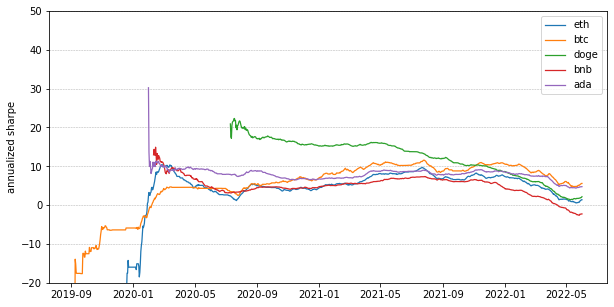

In [95]:
if plot:
    sns.color_palette()
    
    fig, ax = plt.subplots(figsize =(10,5))

    for g in range(0, len(currencies)):
        ax.plot(roll_all[g].index, roll_all[g]['sharpe_365d'], linewidth=1.25)
    
    ax.legend(['eth', 'btc', 'doge', 'bnb', 'ada'])
    
    ax.set_ylim(-20, 50)

    ax.set_ylabel('annualized sharpe')

    ax.grid(axis='y', linestyle='--', linewidth=.5)

    plt.show()

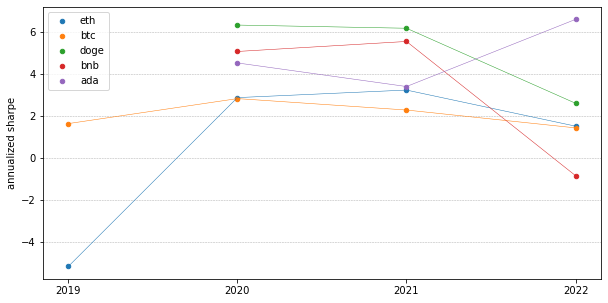

In [96]:
if plot:
    fig, ax = plt.subplots(figsize =(10,5))

    ax.scatter(['2019', '2020', '2021', '2022'], results.loc[('eth')]['ann_sharpe'][:-1], s=20)
    ax.scatter(['2019', '2020', '2021', '2022'], results.loc[('btc')]['ann_sharpe'][:-1], s=20)
    ax.scatter(['2020', '2021', '2022'], results.loc[('doge')]['ann_sharpe'][1:-1], s=20)
    ax.scatter(['2020', '2021', '2022'], results.loc[('bnb')]['ann_sharpe'][1:-1], s=20)
    ax.scatter(['2020', '2021', '2022'], results.loc[('ada')]['ann_sharpe'][1:-1], s=20)

    ax.legend(['eth', 'btc', 'doge', 'bnb', 'ada'])

    ax.plot(['2019', '2020', '2021', '2022'], results.loc[('eth')]['ann_sharpe'][:-1], linewidth=0.5)
    ax.plot(['2019', '2020', '2021', '2022'], results.loc[('btc')]['ann_sharpe'][:-1], linewidth=0.5)
    ax.plot(['2020', '2021', '2022'], results.loc[('doge')]['ann_sharpe'][1:-1], linewidth=0.5)
    ax.plot(['2020', '2021', '2022'], results.loc[('bnb')]['ann_sharpe'][1:-1], linewidth=0.5)
    ax.plot(['2020', '2021', '2022'], results.loc[('ada')]['ann_sharpe'][1:-1], linewidth=0.5)

    ax.set_ylabel('annualized sharpe')


    ax.grid(axis='y', linestyle='--', linewidth=.5)

    plt.show()